<a href="https://colab.research.google.com/github/Mostafaali3/Machine_Learning_Project/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb
!pip install scipy
!pip install antropy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 62.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt
import scipy
from scipy.signal import welch, find_peaks
import antropy as ant

ModuleNotFoundError: No module named 'wfdb'

In [ ]:
file_path = 'Dataset/ECGPCG0001'
record = wfdb.rdheader(file_path)
# There's also wfdb.rdsamp() but idk how to make it work

print("Record Name:", record.record_name)
print("Number of Signals:", record.n_sig)
print("Sampling Frequency (Hz):", record.fs)
print("Signal Names:", record.sig_name)
print("Signal Units:", record.units)
print("Comments:", record.comments)
# Comments don't include the label (walking, sitting, etc.) IT'S IN THE CSV 'ECGPCGSpreadsheet.csv'

Record Name: ECGPCG0001
Number of Signals: 2
Sampling Frequency (Hz): 8000
Signal Names: ['ECG', 'PCG']
Signal Units: ['mV', 'mV']
Comments: ['The simultaneous electrocardiogram and phonocardiogram database']


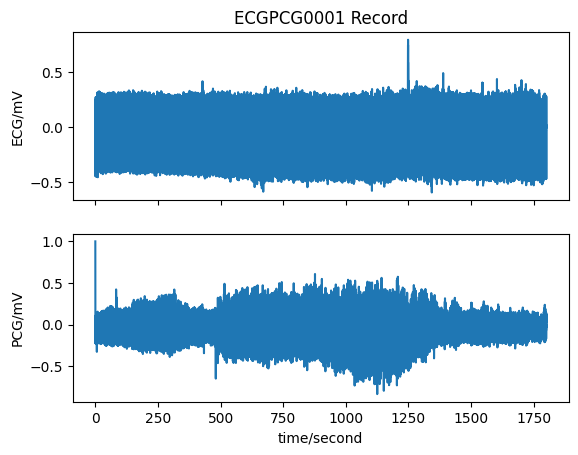

In [ ]:
record = wfdb.rdrecord('Dataset/ECGPCG0001')
wfdb.plot_wfdb(record=record, title='ECGPCG0001 Record')

# Record is 30 mins so it's difficult to visualize in one static plot


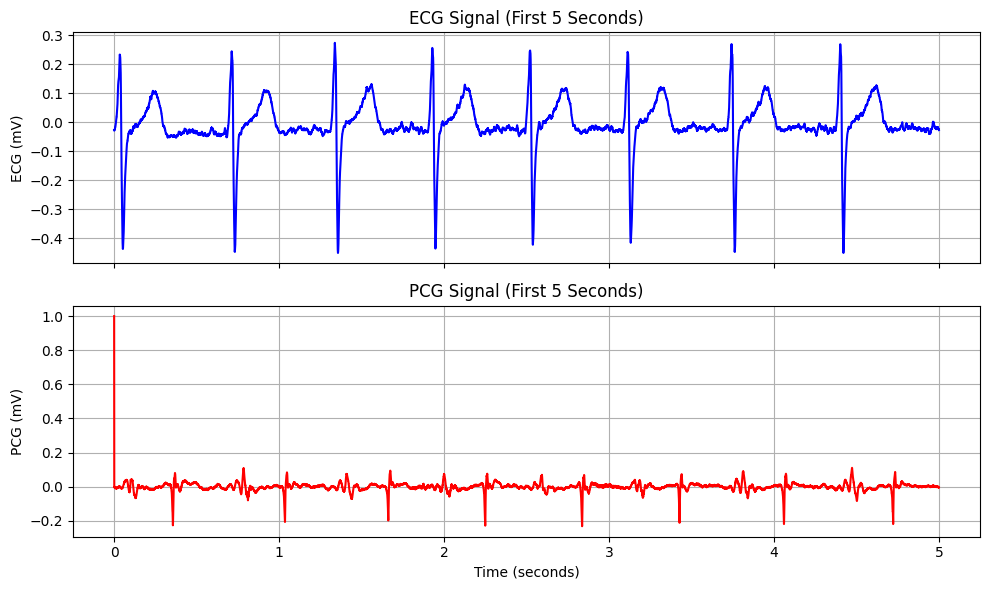

In [ ]:
record = wfdb.rdrecord(file_path)

fs = record.fs  # Sampling frequency
duration = 5
num_samples = int(duration * fs)

ecg_signal = record.p_signal[:num_samples, 0]
pcg_signal = record.p_signal[:num_samples, 1]
time = np.linspace(0, duration, num_samples)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot ECG
ax[0].plot(time, ecg_signal, color='b')
ax[0].set_title("ECG Signal (First 5 Seconds)")
ax[0].set_ylabel("ECG (mV)")
ax[0].grid()

# Plot PCG
ax[1].plot(time, pcg_signal, color='r')
ax[1].set_title("PCG Signal (First 5 Seconds)")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("PCG (mV)")
ax[1].grid()

plt.tight_layout()
plt.show()


In [ ]:
#@title EXAMPLE FEATURE EXTRACTION
record = wfdb.rdrecord('Dataset/ECGPCG0001')
fs = record.fs
duration = 10
num_samples = int(duration * fs)

pcg_signal = record.p_signal[:num_samples, 1]  # Extract PCG
time = np.linspace(0, duration, num_samples)

def detect_s1_s2_intervals(signal, fs):
    """Detect peaks (heart sounds) and compute variability."""
    peaks, _ = find_peaks(signal, height=np.mean(signal))
    intervals = np.diff(peaks) / fs  # Convert to time
    return {
        "S1-S2 Variability": np.std(intervals),
        "Heart Rate": 60 / np.mean(intervals) if len(intervals) > 0 else np.nan
    }

def s1_s2_energy_ratio(signal):
    """Compute S1/S2 energy ratio using basic power analysis."""
    s1_energy = np.sum(signal[:len(signal)//2]**2)
    s2_energy = np.sum(signal[len(signal)//2:]**2)
    return {"S1/S2 Energy Ratio": s1_energy / (s2_energy + 1e-10)}

def spectral_entropy(signal, fs):
    """Compute Spectral Entropy from FFT."""
    f, Pxx = welch(signal, fs=fs, nperseg=min(1024, len(signal)))
    Pxx_norm = Pxx / np.sum(Pxx)  # Normalize power
    entropy = -np.sum(Pxx_norm * np.log(Pxx_norm + 1e-10))  # Shannon Entropy
    return {"Spectral Entropy": entropy}

def low_frequency_power(signal, fs, low_freq=0, high_freq=50):
    """Compute power in low-frequency band (0-50 Hz)."""
    f, Pxx = welch(signal, fs=fs, nperseg=min(1024, len(signal)))
    low_power = np.sum(Pxx[(f >= low_freq) & (f <= high_freq)])
    return {"Power in Low-Frequency Band": low_power}

s1_s2_features = detect_s1_s2_intervals(pcg_signal, fs)
energy_ratio = s1_s2_energy_ratio(pcg_signal)
entropy_feat = spectral_entropy(pcg_signal, fs)
low_freq_power = low_frequency_power(pcg_signal, fs)

all_features = {**s1_s2_features, **energy_ratio, **entropy_feat, **low_freq_power}

print("Extracted Features from PCG Signal (First 10s):")
for key, value in all_features.items():
    print(f"{key}: {value:.4f}")
